In [ ]:
# IMPORTANT: RUN THIS CELL FIRST. AFTER THE SESSION RESTARST YOU CAN RUN THE REST OF THE CELLS.
!pip install catboost
!pip install --upgrade --force-reinstall numpy==1.23.5 --quiet

# Restart runtime to complete installation
import os
os.kill(os.getpid(), 9)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 20.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blosc2 3.2.1 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
bigframes 1.42.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 wh

In [1]:
!pip install --upgrade catboost --quiet

Mounted at /content/drive
📋 Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.74      0.73      0.74       376
           1       0.85      0.86      0.85       663

    accuracy                           0.81      1039
   macro avg       0.80      0.79      0.79      1039
weighted avg       0.81      0.81      0.81      1039



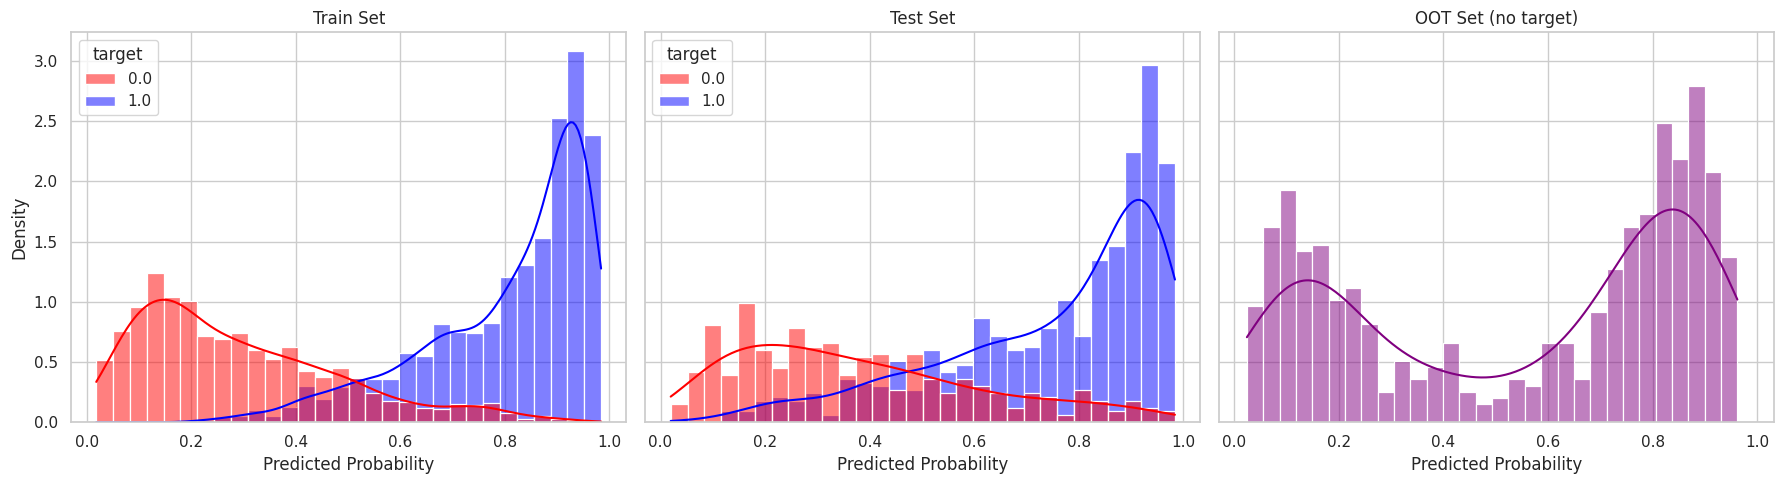

In [2]:
# =================== 1. Mount Google Drive ===================
from google.colab import drive
drive.mount('/content/drive')

# =================== 2. Imports ==============================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# =================== 3. Paths ================================
train_path = "/content/drive/MyDrive/Machine_Learning_project/final_train_top20.parquet"
test_path = "/content/drive/MyDrive/Machine_Learning_project/final_test_top20.parquet"
model_path = "/content/drive/MyDrive/Machine_Learning_project/final_catboost_model.pkl"

sales_test_path = "/content/drive/MyDrive/Machine_Learning_project/sales_test.csv"
crm_test_path = "/content/drive/MyDrive/Machine_Learning_project/crm_test.csv"
finance_test_path = "/content/drive/MyDrive/Machine_Learning_project/finance_test.csv"

# =================== 4. Load Model ===========================
with open(model_path, "rb") as f:
    model = pickle.load(f)

# =================== 5. Load Train/Test ======================
train_df = pd.read_parquet(train_path)
test_df = pd.read_parquet(test_path)

X_train = train_df.drop(columns=["Retained"])
y_train = train_df["Retained"]

X_test = test_df.drop(columns=["Retained"])
y_test = test_df["Retained"]

# =================== 6. Preprocess & Predict OOT (OUT OF TIME) =============

# Load raw OOT data
df_sales = pd.read_csv(sales_test_path, decimal=',')
df_crm = pd.read_csv(crm_test_path, decimal=',')
df_finance = pd.read_csv(finance_test_path, decimal=',')

# Create ID_JOIN
df_sales["ID_JOIN"] = df_sales["ID_SALES"].str.extract(r'(\d+)', expand=False).str.zfill(5)
df_crm["ID_JOIN"] = df_crm["ID_CRM"].str.extract(r'(\d+)', expand=False).str.zfill(5)
df_finance["ID_JOIN"] = df_finance["ID_FINANCE"].str.extract(r'(\d+)', expand=False).str.zfill(5)

# Merge datasets
df_oot = df_sales.merge(df_crm, on="ID_JOIN", how="left").merge(df_finance, on="ID_JOIN", how="left")

# Ordinal mappings
grade_mapping = {'Undefined': 0, 'Elementary': 1, 'Middle': 2, 'High': 3}
size_mapping = {'nan': 0, 'S': 1, 'S-M': 2, 'M-L': 3, 'L': 4}
poverty_map = {'A': 0,'B': 1,'C': 2,'D': 3,'E': -1, '0': -2}
income_map = {val: idx for idx, val in enumerate(list("ABCDEFGHIJKLMNOPQ"), start=1)}

# Apply transformations
df_oot['Poverty_Code'] = df_oot['Poverty_Code'].map(poverty_map).fillna(-3)
df_oot['SchoolGradeTypeLow'] = df_oot['SchoolGradeTypeLow'].map(grade_mapping)
df_oot['SchoolGradeTypeHigh'] = df_oot['SchoolGradeTypeHigh'].map(grade_mapping)
df_oot['SchoolSizeIndicator'] = df_oot['SchoolSizeIndicator'].map(size_mapping)
df_oot['Income_Level'] = df_oot['Income_Level'].apply(lambda x: income_map.get(x, 0))
df_oot["grade_diff"] = df_oot["To_Grade"] - df_oot["From_Grade"]

# Date engineering
for col in ['LastMeeting', 'Departure_Date', 'Initial_System_Date']:
    df_oot[col] = pd.to_datetime(df_oot[col], errors='coerce')
    df_oot[f"{col}_month"] = df_oot[col].dt.month
    df_oot[f"{col}_month_sin"] = np.sin(2 * np.pi * df_oot[f"{col}_month"] / 12)
    df_oot[f"{col}_month_cos"] = np.cos(2 * np.pi * df_oot[f"{col}_month"] / 12)

# Final features
final_features = [
 'Group_State', 'Cancelled_Pax', 'Total_Pax', 'GroupGradeTypeLow', 'FPP_to_School_enrollment',
 'Poverty_Code', 'MDR_High_Grade', 'Income_Level', 'DifferenceTraveltoFirstMeeting',
 'DifferenceTraveltoLastMeeting', 'SchoolSizeIndicator', 'FRP_Active',
 'FRP_Take_up_percent_', 'EZ_Pay_Take_Up_Rate', 'SPR_Group_Revenue', 'grade_diff',
 'LastMeeting_month_cos', 'Departure_Date_month_cos',
 'Initial_System_Date_month_sin', 'Initial_System_Date_month_cos'
]

X_oot = df_oot[final_features]
y_oot_proba = model.predict_proba(X_oot)[:, 1]
y_oot_pred = (y_oot_proba >= 0.5).astype(int)

# =================== 7. Predict Train/Test ===================
y_train_proba = model.predict_proba(X_train)[:, 1]
y_test_proba = model.predict_proba(X_test)[:, 1]

# =================== 8. Classification Report ================

print("📋 Classification Report (Test Set):")
y_test_pred = model.predict(X_test)
print(classification_report(y_test, y_test_pred))

# =================== 9. Seaborn Distributions ================
df_plot = pd.DataFrame({
    'proba': list(y_train_proba) + list(y_test_proba) + list(y_oot_proba),
    'set': (['Train'] * len(y_train_proba)) + (['Test'] * len(y_test_proba)) + (['OOT'] * len(y_oot_proba)),
    'target': list(y_train) + list(y_test) + [None] * len(y_oot_proba)
})

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

# Train
sns.histplot(data=df_plot[df_plot["set"] == "Train"],
             x="proba", hue="target", palette={0: "red", 1: "blue"},
             bins=30, kde=True, stat="density", ax=axes[0])
axes[0].set_title("Train Set")
axes[0].set_xlabel("Predicted Probability")
axes[0].set_ylabel("Density")

# Test
sns.histplot(data=df_plot[df_plot["set"] == "Test"],
             x="proba", hue="target", palette={0: "red", 1: "blue"},
             bins=30, kde=True, stat="density", ax=axes[1])
axes[1].set_title("Test Set")
axes[1].set_xlabel("Predicted Probability")
axes[1].set_ylabel("")

# OOT
sns.histplot(data=df_plot[df_plot["set"] == "OOT"],
             x="proba", color="purple", bins=30, kde=True, stat="density", ax=axes[2])
axes[2].set_title("OOT Set (no target)")
axes[2].set_xlabel("Predicted Probability")
axes[2].set_ylabel("")

plt.tight_layout()
plt.show()

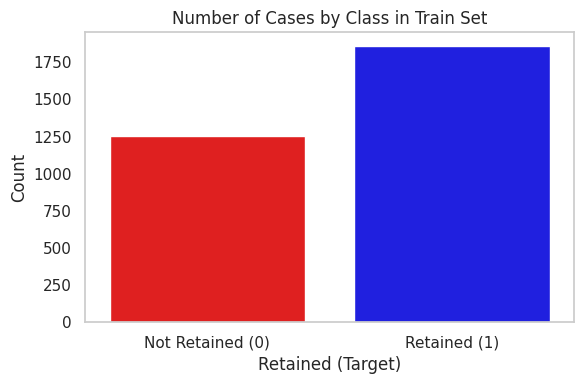

In [11]:
# Wrap y_train in a DataFrame for compatibility
df_target = pd.DataFrame({'Retained': y_train})

# Plot with hue equal to x, and assign palette
plt.figure(figsize=(6, 4))
sns.countplot(data=df_target, x='Retained', hue='Retained', palette={0: "red", 1: "blue"}, legend=False)

plt.title("Number of Cases by Class in Train Set")
plt.xlabel("Retained (Target)")
plt.ylabel("Count")
plt.xticks([0, 1], ['Not Retained (0)', 'Retained (1)'])
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [12]:
# Get class predictions from the model on test set
y_pred = model.predict(X_test)

# Print classification report
print("📋 Classification Report (Test Set):")
print(classification_report(y_test, y_pred))

📋 Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.74      0.73      0.74       376
           1       0.85      0.86      0.85       663

    accuracy                           0.81      1039
   macro avg       0.80      0.79      0.79      1039
weighted avg       0.81      0.81      0.81      1039



Confusion Matrix (Test Set):
[[274 102]
 [ 95 568]]


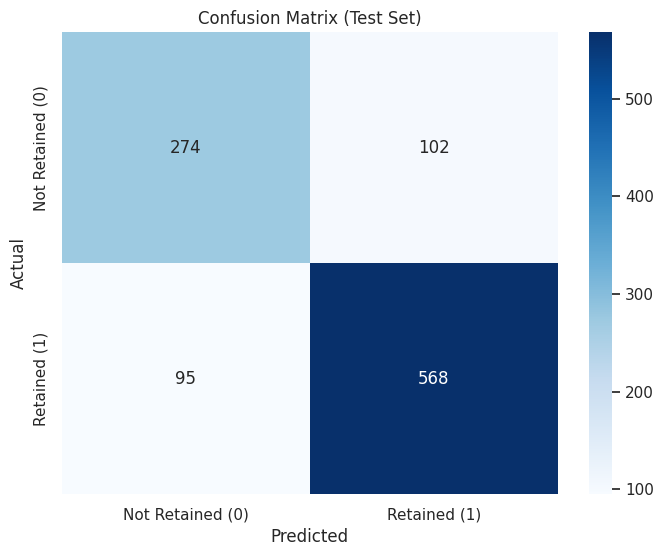

In [13]:
# Compute and print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix (Test Set):")
print(conf_matrix)

# Optionally, visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Not Retained (0)', 'Retained (1)'],
            yticklabels=['Not Retained (0)', 'Retained (1)'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test Set)")
plt.show()

In [14]:
# Get original IDs
id_sales = df_sales["ID_SALES"].reset_index(drop=True)

# Create a DataFrame with predictions
oot_predictions = pd.DataFrame({
    "ID_SALES": id_sales,
    "Retained": y_oot_pred,
    "Probability": y_oot_proba
})

# Display first few rows
print(oot_predictions.head())

  ID_SALES  Retained  Probability
0  CC1040A         1     0.959047
1  CC1525A         1     0.870116
2  CC2011A         0     0.178117
3  CD1132A         1     0.763467
4  CD1178T         1     0.824199


In [21]:
oot_predictions.to_csv("/content/drive/MyDrive/Machine_Learning_project/oot_predictions_with_ids.csv", index=False)

In [4]:
# =================== 10. Load Overfitted Model ===================
overfit_model_path = "/content/drive/MyDrive/Machine_Learning_project/final_catboost_model_overfit.pkl"

with open(overfit_model_path, "rb") as f:
    overfit_model = pickle.load(f)

# =================== 11. Predict OOT with Overfitted Model ================
y_oot_proba_overfit = overfit_model.predict_proba(X_oot)[:, 1]
y_oot_pred_overfit = (y_oot_proba_overfit >= 0.5).astype(int)

# =================== 12. Save OOT Predictions (Overfitted Model) ===========
# Get original IDs
id_sales = df_sales["ID_SALES"].reset_index(drop=True)

# Create DataFrame with predictions
oot_predictions_overfit = pd.DataFrame({
    "ID_SALES": id_sales,
    "Retained": y_oot_pred_overfit,
    "Probability": y_oot_proba_overfit
})

# Display preview
print("📦 OOT Predictions from Overfitted Model:")
print(oot_predictions_overfit.head())

# Save to CSV with 'overfitted' in the filename
overfit_predictions_path = "/content/drive/MyDrive/Machine_Learning_project/oot_predictions_overfitted.csv"
oot_predictions_overfit.to_csv(overfit_predictions_path, index=False)

print("✅ Saved OOT predictions to:", overfit_predictions_path)

📦 OOT Predictions from Overfitted Model:
  ID_SALES  Retained  Probability
0  CC1040A         1     0.960007
1  CC1525A         1     0.928898
2  CC2011A         0     0.042612
3  CD1132A         1     0.759965
4  CD1178T         1     0.856480
✅ Saved OOT predictions to: /content/drive/MyDrive/Machine_Learning_project/oot_predictions_overfitted.csv
